In [1]:
import re
import pandas as pd
import os
from time import time  # To time our operations
from collections import defaultdict  # For word frequency
import logging  # Setting up the loggings to monitor gensim
import multiprocessing
from gensim.models import Word2Vec
import spacy
import numpy as np
from matplotlib import pyplot as plt

In [2]:
os.getcwd()
os.chdir('/Users/olivia/Desktop/Data Mining&Stat Learn/Projects/Final project') 

In [3]:
mobile = pd.read_csv(r"appleStore_description.csv")
mobile.head()

,id,track_name,size_bytes,app_desc
0,281656475,PAC-MAN Premium,100788224,"SAVE 20%, now only $3.99 for a limited time!\n..."
1,281796108,Evernote - stay organized,158578688,Let Evernote change the way you organize your ...
2,281940292,"WeatherBug - Local Weather, Radar, Maps, Alerts",100524032,Download the most popular free weather app pow...
3,282614216,"eBay: Best App to Buy, Sell, Save! Online Shop...",128512000,The eBay app is the best way to find anything ...
4,282935706,Bible,92774400,On more than 250 million devices around the wo...


In [4]:
mobile.shape

(7197, 4)

In [5]:
mobile.isnull().sum()

id            0
track_name    0
size_bytes    0
app_desc      0
dtype: int64

In [6]:
nlp = spacy.load('en', disable=['ner', 'parser']) 
# disabling Named Entity Recognition for speed
def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word.
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)

In [7]:
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in 
                  mobile['app_desc'])

In [8]:
t = time()
txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, 
                                         n_threads=-1)]
print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 1.57 mins


In [9]:
mobile_clean = pd.DataFrame({'clean': txt})
mobile_clean = mobile_clean.dropna().drop_duplicates()
mobile_clean.shape

(6834, 1)

In [10]:
mobile_clean.head(6)

,clean
0,save limited time popular video game arcade hi...
1,let evernote change way organize personal prof...
2,download popular free weather app power large ...
3,ebay app good way find need dress handbag fash...
4,million device world people read listen watch ...
5,winner good game rd place winner good app ho...


In [11]:
from gensim.models.phrases import Phrases, Phraser

In [12]:
sent = [row.split() for row in mobile_clean['clean']]

In [13]:
phrases = Phrases(sent, min_count=10, progress_per=1000) 

In [14]:
bigram = Phraser(phrases)

In [15]:
sentences = bigram[sent]

In [16]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

39897

In [17]:
word_freq['game']

12568

In [18]:
word_freq['adventure']

1229

In [19]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['game', 'app', 'play', 'new', 's', 'feature', 'com', 'world', 'use', 'time']

In [20]:
#word_freq

In [21]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer

In [22]:
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=100,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

In [23]:
t = time()

w2v_model.build_vocab(sentences, progress_per=1000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 0.05 mins


In [24]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, 
                report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 1.64 mins


In [25]:
w2v_model.init_sims(replace=True)

In [26]:
words = list(w2v_model.wv.vocab)
#print(words)

In [27]:
#print(w2v_model['game']) #size=100

In [28]:
w2v_model.wv.save_word2vec_format('model.bin',binary=False)

In [29]:
game = w2v_model.wv.most_similar(positive=["game"],)

In [30]:
game

[('addictive', 0.5528801679611206),
 ('gameplay', 0.5200115442276001),
 ('arcade_style', 0.5196410417556763),
 ('fun_addictive', 0.5154783725738525),
 ('addicting', 0.5084647536277771),
 ('entertaining', 0.5078068375587463),
 ('physics_base', 0.4913872480392456),
 ('play', 0.48764297366142273),
 ('slidetoplay', 0.48269978165626526),
 ('blitz', 0.47887083888053894)]

In [31]:
w2v_model.wv.most_similar(positive=["play"],)

[('local_multiplayer', 0.5993112325668335),
 ('arcade_mode', 0.5951459407806396),
 ('enjoy', 0.5648280382156372),
 ('asynchronous', 0.5374651551246643),
 ('split_screen', 0.5316224098205566),
 ('player', 0.5229854583740234),
 ('fun', 0.5155184268951416),
 ('ai_opponent', 0.5128617286682129),
 ('multiplayer_mode', 0.5076355934143066),
 ('online_multiplayer', 0.502300500869751)]

In [32]:
w2v_model.wv.most_similar(positive=["physics_base"],)

[('puzzler', 0.7122789621353149),
 ('mind_blow', 0.6639015674591064),
 ('slidetoplay', 0.6565843820571899),
 ('difficult_master', 0.6513079404830933),
 ('kart', 0.644499659538269),
 ('fast_paced', 0.6402285695075989),
 ('gorgeous_graphic', 0.6401410102844238),
 ('platformer', 0.6298312544822693),
 ('motocross', 0.6296177506446838),
 ('frantic', 0.6239587664604187)]

In [33]:
w2v_model.wv.most_similar(positive=["brain_teaser"],)

[('puzzle', 0.7696691155433655),
 ('riddle', 0.6875176429748535),
 ('addictive', 0.6519749164581299),
 ('mind_bend', 0.6412795782089233),
 ('fun_addictive', 0.6315265893936157),
 ('challenging', 0.612358808517456),
 ('puzzle_solve', 0.6011332273483276),
 ('entertaining', 0.5941802263259888),
 ('point_click', 0.5937354564666748),
 ('captivate', 0.5903615951538086)]

In [34]:
w2v_model.wv.most_similar(positive=["multiplayer"],)

[('asynchronous', 0.7979418039321899),
 ('co_op', 0.7783390283584595),
 ('cooperative', 0.7533673048019409),
 ('online_multiplayer', 0.7527625560760498),
 ('multiplayer_mode', 0.728319525718689),
 ('cross_platform', 0.7161744236946106),
 ('compete_player', 0.7032915353775024),
 ('versus', 0.6976794600486755),
 ('head_head', 0.6941928863525391),
 ('local_multiplayer', 0.6845372915267944)]

In [35]:
w2v_model.wv.most_similar(positive=["split_screen"])

[('replay_kit', 0.6659030318260193),
 ('asynchronous', 0.6538444757461548),
 ('game_centre', 0.6211212277412415),
 ('local_multiplayer', 0.6147786378860474),
 ('difficulty_setting', 0.6124118566513062),
 ('multiplayer', 0.5999433994293213),
 ('challenge_friend', 0.5956044793128967),
 ('mode', 0.5945631265640259),
 ('head_head', 0.5898910164833069),
 ('ai_opponent', 0.5892370939254761)]

In [36]:
w2v_model.wv.most_similar(positive=["arcade_mode"])

[('try_beat', 0.6577693223953247),
 ('global_leaderboard', 0.6573965549468994),
 ('high_score', 0.6564264297485352),
 ('test_skill', 0.6273015141487122),
 ('ultimate_test', 0.6236104965209961),
 ('difficulty_mode', 0.6144174337387085),
 ('challenge', 0.6122860312461853),
 ('game_centre', 0.6066798567771912),
 ('challenge_friend', 0.6019773483276367),
 ('earn_achievement', 0.5955932140350342)]

In [37]:
w2v_model.wv.most_similar(positive=["productivity"])

[('reviewer', 0.4792308211326599),
 ('techcrunch', 0.4756331443786621),
 ('ny_time', 0.46086373925209045),
 ('smarter', 0.4559674561023712),
 ('accolade', 0.45278650522232056),
 ('cent', 0.45029497146606445),
 ('increase', 0.4412265717983246),
 ('health_fitness', 0.4407627582550049),
 ('retail', 0.4390009641647339),
 ('china', 0.4376179277896881)]

In [38]:
w2v_model.wv.most_similar(positive=["fitness"])

[('personal_trainer', 0.7239846587181091),
 ('bodyweight', 0.7030612230300903),
 ('training_plan', 0.6801081299781799),
 ('workout', 0.6785677671432495),
 ('fizzup', 0.6329860091209412),
 ('yoga', 0.6312828063964844),
 ('myfitnesspal', 0.6221705675125122),
 ('ab', 0.6159507036209106),
 ('health_fitness', 0.6156076788902283),
 ('nutrition', 0.5841165781021118)]

In [39]:
w2v_model.wv.similarity('asynchronous', 'cross_platform')

0.69644946

In [4]:
import numpy as np
import matplotlib.pyplot as plt

([<matplotlib.axis.XTick at 0x7fba61248590>,
 <a list of 10 Text xticklabel objects>)

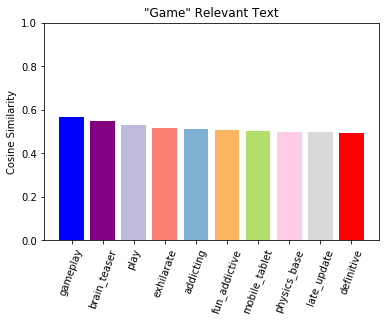

In [5]:
#game
height = [0.565, 0.549,0.532, 0.517,0.513,0.505,0.501, 0.496,0.496,0.494]
bars = ('gameplay', 'brain_teaser', 'play', 'exhilarate','addicting',
        'fun_addictive','mobile_tablet','physics_base','late_update','definitive')
y_pos = np.arange(len(bars))
palette = plt.get_cmap('Set3')
plt.title('"Game" Relevant Text')
plt.ylabel('Cosine Similarity')
# Limits for the Y axis
plt.ylim(0,1)
# Create names
plt.bar(y_pos, height,color=['blue','purple',palette(2),palette(3),palette(4),
                             palette(5),palette(6),palette(7),palette(8),'red'])
plt.xticks(y_pos, bars,rotation=70)

([<matplotlib.axis.XTick at 0x7fba617a1710>,
 <a list of 10 Text xticklabel objects>)

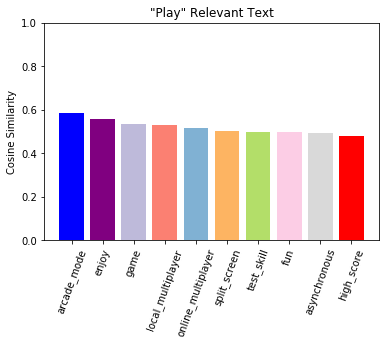

In [6]:
#play
height = [0.584,0.556,0.532,0.531,0.513, 0.501,0.497,0.495,0.494,0.477]
bars = ('arcade_mode','enjoy','game','local_multiplayer', 'online_multiplayer',
        'split_screen','test_skill','fun','asynchronous','high_score')
y_pos = np.arange(len(bars))
palette = plt.get_cmap('Set3')
plt.title('"Play" Relevant Text')
plt.ylabel('Cosine Similarity')
# Limits for the Y axis
plt.ylim(0,1)
# Create names
plt.bar(y_pos, height,color=['blue','purple',palette(2),palette(3),palette(4),
                             palette(5),palette(6),palette(7),palette(8),'red'])
plt.xticks(y_pos, bars,rotation=70)

([<matplotlib.axis.XTick at 0x7fba61b79250>,
 <a list of 10 Text xticklabel objects>)

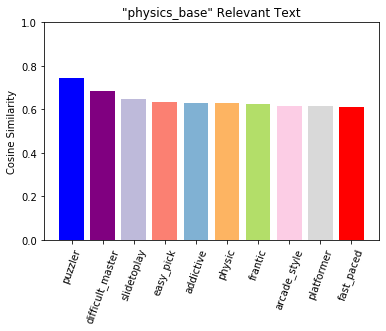

In [7]:
#physics_base
height = [0.745,0.684,0.645,0.632,0.628,0.627,0.622,0.614,0.614,0.612]
bars = ('puzzler','difficult_master', 'slidetoplay', 'easy_pick', 'addictive',
        'physic', 'frantic', 'arcade_style', 'platformer','fast_paced')
y_pos = np.arange(len(bars))
palette = plt.get_cmap('Set3')
plt.title('"physics_base" Relevant Text')
plt.ylabel('Cosine Similarity')
# Limits for the Y axis
plt.ylim(0,1)
# Create names
plt.bar(y_pos, height,color=['blue','purple',palette(2),palette(3),palette(4),
                             palette(5),palette(6),palette(7),palette(8),'red'])
plt.xticks(y_pos, bars,rotation=70)

([<matplotlib.axis.XTick at 0x7fba5f90ce10>,
 <a list of 10 Text xticklabel objects>)

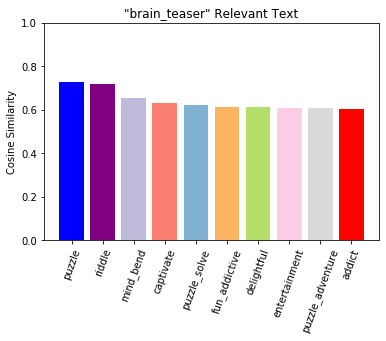

In [8]:
#brain_teaser
height = [0.726,0.718,0.656,0.633,0.620,0.614,0.613,0.609,0.606,0.601]
bars = ('puzzle','riddle', 'mind_bend', 'captivate', 'puzzle_solve',
        'fun_addictive', 'delightful', 'entertainment', 'puzzle_adventure','addict')
y_pos = np.arange(len(bars))
palette = plt.get_cmap('Set3')
plt.title('"brain_teaser" Relevant Text')
plt.ylabel('Cosine Similarity')
# Limits for the Y axis
plt.ylim(0,1)
# Create names
plt.bar(y_pos, height,color=['blue','purple',palette(2),palette(3),palette(4),
                             palette(5),palette(6),palette(7),palette(8),'red'])
plt.xticks(y_pos, bars,rotation=70)

([<matplotlib.axis.XTick at 0x7fba61b5c490>,
 <a list of 10 Text xticklabel objects>)

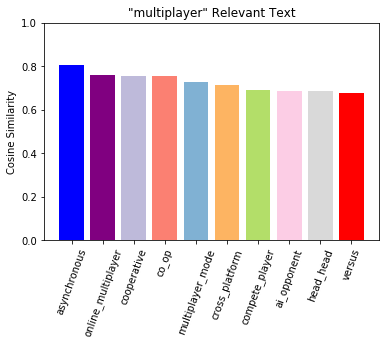

In [9]:
#multiplayer
height = [0.804,0.761,0.755,0.753,0.727,0.714,0.692,0.686,0.684,0.678]
bars = ('asynchronous','online_multiplayer', 'cooperative', 'co_op', 
        'multiplayer_mode','cross_platform', 'compete_player', 'ai_opponent', 
        'head_head','versus')
y_pos = np.arange(len(bars))
palette = plt.get_cmap('Set3')
plt.title('"multiplayer" Relevant Text')
plt.ylabel('Cosine Similarity')
# Limits for the Y axis
plt.ylim(0,1)
# Create names
plt.bar(y_pos, height,color=['blue','purple',palette(2),palette(3),palette(4),
                             palette(5),palette(6),palette(7),palette(8),'red'])
plt.xticks(y_pos, bars,rotation=70)

([<matplotlib.axis.XTick at 0x7fba61da0a10>,
 <a list of 10 Text xticklabel objects>)

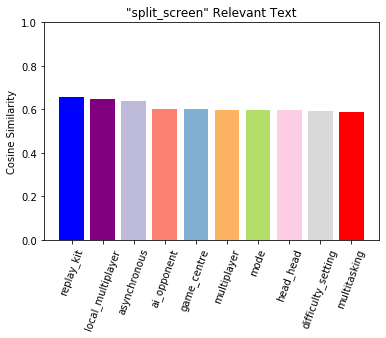

In [10]:
#split_screen
height = [0.657,0.649,0.637,0.603,0.603,0.599,0.599, 0.598,0.594,0.590]
bars = ('replay_kit','local_multiplayer','asynchronous','ai_opponent','game_centre',
        'multiplayer','mode','head_head','difficulty_setting','multitasking')
y_pos = np.arange(len(bars))
palette = plt.get_cmap('Set3')
plt.title('"split_screen" Relevant Text')
plt.ylabel('Cosine Similarity')
# Limits for the Y axis
plt.ylim(0,1)
# Create names
plt.bar(y_pos, height,color=['blue','purple',palette(2),palette(3),palette(4),
                             palette(5),palette(6),palette(7),palette(8),'red'])
plt.xticks(y_pos, bars,rotation=70)

([<matplotlib.axis.XTick at 0x7fba61f97fd0>,
 <a list of 10 Text xticklabel objects>)

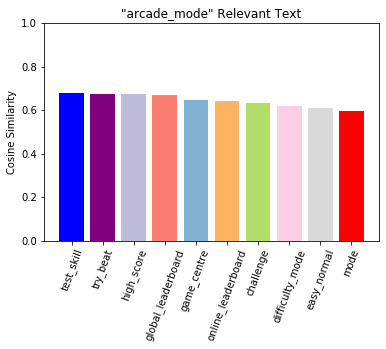

In [11]:
#arcade_mode
height = [0.678,0.676,0.674,0.670,0.646,0.643,0.634,0.617, 0.609, 0.594]
bars = ('test_skill','try_beat','high_score','global_leaderboard','game_centre',
        'online_leaderboard','challenge','difficulty_mode','easy_normal','mode')
y_pos = np.arange(len(bars))
palette = plt.get_cmap('Set3')
plt.title('"arcade_mode" Relevant Text')
plt.ylabel('Cosine Similarity')
# Limits for the Y axis
plt.ylim(0,1)
# Create names
plt.bar(y_pos, height,color=['blue','purple',palette(2),palette(3),palette(4),
                             palette(5), palette(6),palette(7),palette(8),'red'])
plt.xticks(y_pos, bars,rotation=70)